# Assignment 3/4 - Python

In [3]:
#Importar librerias Double Lasso (PD6)
import pandas as pd
import numpy as np
from scipy.stats import norm
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LassoCV
import patsy
import warnings
warnings.simplefilter('ignore')
np.random.seed(1234)
import sys
sys.path.insert(1, "./hdmpy")
from sklearn.base import BaseEstimator
#Importar Librerias DAGs (PD7)
import statsmodels.api as sms

## Part 1: Double Lasso and DAGs (20 points)

### 1. Consider the US census data from the year 2015 to analyse the effect of college graduate (clg) status and it’s interaction effects with gender (sex), location (mw, so,we, ne) and both on wage jointly. All other variables denote some other socio-economic characteristics, e.g. marital status, occupation, and experience

In [4]:
file = "https://raw.githubusercontent.com/CausalAIBook/MetricsMLNotebooks/main/data/wage2015_subsample_inference.csv"
data = pd.read_csv(file)

In [5]:
data.describe()

,wage,lwage,sex,shs,hsg,scl,clg,ad,mw,so,we,ne,exp1,exp2,exp3,exp4,occ,occ2,ind,ind2
count,5150.000000,5150.000000,5150.000000,5150.000000,5150.000000,5150.000000,5150.000000,5150.000000,5150.000000,5150.000000,5150.000000,5150.000000,5150.000000,5150.000000,5150.000000,5150.000000,5150.000000,5150.000000,5150.000000,5150.000000
mean,23.410410,2.970787,0.444466,0.023301,0.243883,0.278058,0.317670,0.137087,0.259612,0.296505,0.216117,0.227767,13.760583,3.018925,8.235867,25.118038,5310.737476,11.670874,6629.154951,13.316893
std,21.003016,0.570385,0.496955,0.150872,0.429465,0.448086,0.465616,0.343973,0.438464,0.456761,0.411635,0.419432,10.609465,4.000904,14.488962,53.530225,11874.356080,6.966684,5333.443992,5.701019
min,3.021978,1.105912,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,10.000000,1.000000,370.000000,2.000000
25%,13.461538,2.599837,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,0.250000,0.125000,0.062500,1740.000000,5.000000,4880.000000,9.000000
50%,19.230769,2.956512,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,10.000000,1.000000,1.000000,1.000000,4040.000000,13.000000,7370.000000,14.000000
75%,27.777778,3.324236,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,21.000000,4.410000,9.261000,19.448100,5610.000000,17.000000,8190.000000,18.000000
max,528.845673,6.270697,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,47.000000,22.090000,103.823000,487.968100,100000.000000,22.000000,100000.000000,22.000000


In [6]:
#Comprobación de Dummys
print(data[['sex', 'shs','hsg','scl','clg','ad', 'mw', 'so', 'we', 'ne']].nunique())


sex    2
shs    2
hsg    2
scl    2
clg    2
ad     2
mw     2
so     2
we     2
ne     2
dtype: int64


1.1 Generate the dataset with all the two-way interactions between variables.


In [7]:
#Definir los regresores y la "Y"
y = np.log(data['wage']).values #Y=Log del salario
Z = data.drop(['wage', 'lwage'], axis=1) #Todo menos el salario, los regresores
Z.columns

Index(['sex', 'shs', 'hsg', 'scl', 'clg', 'ad', 'mw', 'so', 'we', 'ne', 'exp1',
       'exp2', 'exp3', 'exp4', 'occ', 'occ2', 'ind', 'ind2'],
      dtype='object')

In [8]:
#Aqui genero las interacciones con las variables, como en la PD6 (mismo codigos y logica)
Zcontrols = patsy.dmatrix('0 + (shs + hsg + scl + sex + C(occ2) + C(ind2) + mw + so + we + exp1 + exp2 + exp3 + exp4)**2',
                          Z, return_type='dataframe')
#"0+": Asegura que no se agregue intercepto a las variables generadas
#"**2": Esto genera las interacciones de todas las var, de forma recursiva (o sea entre toda las variables)
#C():Asegura que las categoricas se manejen como Dummys
Zcontrols = Zcontrols - Zcontrols.mean(axis=0)  # Resta la media de cada columna para centrar la matriz en torno a su media, las var tienen media cero y es mejor para el modelo

#Este bloque genera una nueva matriz de diseño para las variables que se utilizarán para modelar la heterogeneidad de los efectos

In [9]:
#Este bloque genera una nueva matriz de diseño para las variables que se utilizarán para modelar la heterogeneidad de los efectos
Zhet = patsy.dmatrix('0 + (shs+hsg+scl+sex+mw+so+we+exp1+exp2+exp3+exp4)',
                     Z, return_type='dataframe')
Zhet = Zhet - Zhet.mean(axis=0)
#no genera interacciones, solo crea un conjunto de variables de heterogeneidad que se usarán para modelar los efectos heterogéneos de manera lineal.

In [10]:
#Ahora, genero las interacciones entre la variable clg con las otras varibles 
Zhet['clg'] = Z['clg']
Zinteractions = patsy.dmatrix('0 + clg + clg * (shs+hsg+scl+sex+mw+so+we+exp1+exp2+exp3+exp4)',
                              Zhet, return_type='dataframe')
Zinteractions = Zinteractions - Zinteractions.mean(axis=0) #Centro al rededor de la media
interaction_cols = [c for c in Zinteractions.columns if c.startswith('clg')]
#sex * (shs...exp4): genera todas las interacciones entre clg y las demás variables de heterogeneidad

In [11]:
print(Zinteractions)

          clg       shs       hsg       scl       sex        mw        so  \
0     0.68233 -0.023301 -0.243883 -0.278058  0.555534 -0.259612 -0.296505   
1     0.68233 -0.023301 -0.243883 -0.278058 -0.444466 -0.259612 -0.296505   
2    -0.31767 -0.023301  0.756117 -0.278058 -0.444466 -0.259612 -0.296505   
3    -0.31767 -0.023301 -0.243883 -0.278058  0.555534 -0.259612 -0.296505   
4     0.68233 -0.023301 -0.243883 -0.278058  0.555534 -0.259612 -0.296505   
...       ...       ...       ...       ...       ...       ...       ...   
5145  0.68233 -0.023301 -0.243883 -0.278058 -0.444466 -0.259612 -0.296505   
5146 -0.31767 -0.023301 -0.243883  0.721942  0.555534 -0.259612 -0.296505   
5147 -0.31767 -0.023301 -0.243883 -0.278058 -0.444466 -0.259612 -0.296505   
5148 -0.31767 -0.023301  0.756117 -0.278058 -0.444466 -0.259612 -0.296505   
5149 -0.31767 -0.023301 -0.243883 -0.278058 -0.444466 -0.259612 -0.296505   

            we       exp1      exp2  ...   clg:hsg   clg:scl   clg:sex  \
0

In [12]:
print(Zinteractions.mean())

clg         6.746491e-16
shs        -5.863473e-16
hsg        -1.401791e-16
scl        -3.350287e-16
sex        -9.729003e-17
mw         -2.835531e-15
so         -7.651269e-16
we         -3.178571e-14
exp1       -2.105878e-15
exp2        1.642699e-16
exp3        9.074941e-16
exp4        8.129161e-15
clg:shs    -3.217323e-17
clg:hsg    -2.122876e-15
clg:scl    -2.695244e-15
clg:sex     9.854509e-17
clg:mw     -7.469423e-16
clg:so     -1.734812e-15
clg:we      7.880611e-15
clg:exp1   -2.305741e-14
clg:exp2   -2.799271e-16
clg:exp3   -1.155322e-15
clg:exp4   -3.801059e-15
dtype: float64


In [13]:
#Todas las var, juntarlas
X = pd.concat([Zinteractions, Zcontrols], axis=1)
X.shape

(5150, 1002)

1.2 Use the double lasso technique to find the effect of the treatment and it’s relevant interactions on the wage. To tune the penalization parameter in the lasso step, cross-validate it.

In [14]:
#Definición de la RLasso
class RLasso(BaseEstimator):
    def __init__(self, *, post=True):
        self.post = post  # Parámetro que indica si se deben hacer ajustes adicionales después del Lasso
        
    def fit(self, X, y):
        #Todo esto debajo es para la implementacion del método Lasso
        #Se usa LassoCV para aplicar Lasso con validación cruzada (Nos pide la pregunta)
        self.lasso = LassoCV(cv=5)  # Usamos LassoCV con validación cruzada de 5 pliegues
        self.lasso.fit(X, y)  # Ajusta el modelo Lasso con los datos X (predictores) y y (variable objetivo)
        return self
    
    def predict(self, X):
        # Predice usando el modelo Lasso ajustado
        return np.dot(X, self.lasso.coef_) + self.lasso.intercept_

# LassoCV se ajusta automáticamente al conjunto de datos y determina el mejor valor de alpha para la penalización
#Esto es para realizar Lasso en dos contextos diferentes: con la variable dependiente y con la variable de tratamiento

In [15]:
def lasso_model():
    return RLasso(post=False)

In [16]:
alpha = {}
res_y, res_D, epsilon = {}, {}, {}
for c in interaction_cols:
    print(f"Double Lasso for target variable {c}")
    D = X[c].values
    W = X.drop([c], axis=1)
    res_y[c] = y - lasso_model().fit(W, y).predict(W)
    res_D[c] = D - lasso_model().fit(W, D).predict(W)
    final = LinearRegression(fit_intercept=False).fit(res_D[c].reshape(-1, 1), res_y[c])
    epsilon[c] = res_y[c] - final.predict(res_D[c].reshape(-1, 1))
    alpha[c] = [final.coef_[0]]

# Calculate the covariance matrix of the estimated parameters
V = np.zeros((len(interaction_cols), len(interaction_cols)))
for it, c in enumerate(interaction_cols):
    Jc = np.mean(res_D[c]**2)
    for itp, cp in enumerate(interaction_cols):
        Jcp = np.mean(res_D[cp]**2)
        Sigma = np.mean(res_D[c] * epsilon[c] * epsilon[cp] * res_D[cp])
        V[it, itp] = Sigma / (Jc * Jcp)

# Calculate standard errors for each parameter
n = X.shape[0]
for it, c in enumerate(interaction_cols):
    alpha[c] += [np.sqrt(V[it, it] / n)]

Double Lasso for target variable clg
Double Lasso for target variable clg:shs
Double Lasso for target variable clg:hsg
Double Lasso for target variable clg:scl
Double Lasso for target variable clg:sex
Double Lasso for target variable clg:mw
Double Lasso for target variable clg:so
Double Lasso for target variable clg:we
Double Lasso for target variable clg:exp1
Double Lasso for target variable clg:exp2
Double Lasso for target variable clg:exp3
Double Lasso for target variable clg:exp4


1.3 Report a summary of the estimation of the parameters of interest.

In [17]:
#Ahora se pasa a crear un dataframe con los resultados obtenidos
df = pd.DataFrame.from_dict(alpha, orient='index', columns=['point', 'stderr'])

#Cálculo de los p-valores y los intervalos de confianza
summary = pd.DataFrame()
summary['Estimate'] = df['point']  #Aqui se estiman de los coeficientes
summary['Std. Error'] = df['stderr']  # Aqui se van a estimar los errores estándar
summary['p-value'] = norm.sf(np.abs(df['point'] / df['stderr']), loc=0, scale=1) * 2  # p-valores
#Lo de abajo son los intervalos de confianza
summary['ci_lower'] = df['point'] - 1.96 * df['stderr']  
summary['ci_upper'] = df['point'] + 1.96 * df['stderr'] 

print(summary)

          Estimate  Std. Error   p-value  ci_lower  ci_upper
clg      -0.031289    0.022449  0.163384 -0.075288  0.012711
clg:shs   1.343918    0.983540  0.171810 -0.583820  3.271657
clg:hsg   0.128400    0.093969  0.171810 -0.055779  0.312579
clg:scl   0.112619    0.082420  0.171810 -0.048923  0.274161
clg:sex  -0.011743    0.030430  0.699571 -0.071387  0.047900
clg:mw    0.033963    0.032328  0.293446 -0.029399  0.097325
clg:so   -0.109135    0.055331  0.048563 -0.217584 -0.000686
clg:we   -0.094215    0.031731  0.002986 -0.156406 -0.032023
clg:exp1 -0.008597    0.002445  0.000437 -0.013389 -0.003805
clg:exp2 -0.029378    0.012566  0.019393 -0.054007 -0.004749
clg:exp3 -0.014934    0.007006  0.033037 -0.028666 -0.001202
clg:exp4  0.000457    0.001117  0.682499 -0.001732  0.002645


In [18]:
Drootinv = np.diagflat(1 / np.sqrt(np.diag(V)))
scaledCov = Drootinv @ V @ Drootinv
np.random.seed(123)
U = np.random.multivariate_normal(np.zeros(scaledCov.shape[0]), scaledCov, size=10000)
z = np.max(np.abs(U), axis=1)
c = np.percentile(z, 95)

summary = pd.DataFrame()
summary['Estimate'] = df['point']
summary['CI lower'] = df['point'] - c * df['stderr']
summary['CI upper'] = df['point'] + c * df['stderr']
summary

,Estimate,CI lower,CI upper
clg,-0.031289,-0.092366,0.029789
clg:shs,1.343918,-1.332038,4.019875
clg:hsg,0.128400,-0.127265,0.384064
clg:scl,0.112619,-0.111623,0.336861
clg:sex,-0.011743,-0.094536,0.071050
clg:mw,0.033963,-0.053992,0.121918
clg:so,-0.109135,-0.259676,0.041406
clg:we,-0.094215,-0.180545,-0.007884
clg:exp1,-0.008597,-0.015249,-0.001946
clg:exp2,-0.029378,-0.063567,0.004811


1.4 Interpret your results. In which group does the college graduate status has more impact over the wage?

El estatus de graduado universitario tiene un impacto negativo en el salario en la región "we" (coeficiente = -0.094215), lo que indica que los graduados universitarios ganan menos que los no graduados en esta ubicación. Además, la interacción con el grupo de menor experiencia (exp1) muestra un efecto negativo significativo (coeficiente = -0.008597), sugiriendo que los graduados universitarios en este grupo tienen salarios más bajos que los no graduados.

Por otro lado, algunas interacciones no son significativas:

    clg (género): El estatus de graduado universitario no afecta significativamente el salario según el género (valor p = 0.699571).
    clg (otra variable): Esta interacción también es no significativa (valor p = 0.171810), indicando que el estatus de graduado universitario no influye de manera diferente según esta variable.
    clg, clg, clg: Estas interacciones tampoco son significativas (valor p > 0.05), lo que sugiere que el efecto del estatus de graduado universitario no varía según educación secundaria (hsg), localización (scl) ni la ubicación "mw".

### 2. For the following examples, draw a coherent Directed Acyclic Graph and indicate the confounders, colliders and the proper controls (if they exist).

2.1 You are trying to study the effect of youth smoking on lung function. Your dataset contains the following variables:

## Part 2: Bootstrapping and Decision Trees (20 points)

In [23]:

from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, plot_tree
from sklearn.model_selection import train_test_split, KFold, cross_validate
from ISLP.models import ModelSpec as MS
from sklearn.datasets import load_iris
from ISLP import load_data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

^C



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


ValueError: numpy.dtype size changed, may indicate binary incompatibility. Expected 96 from C header, got 88 from PyObject

### 3. Consider the Hitters dataset provided by the ISLR package. This dataset contains several features related to the hitters of the Major League Baseball from the 1986 and 1987 seasons.

3.1 Generate the dataset such that the categorical variables are transformed to dummies. Make sure you drop the missing observations if there is any

In [ ]:
Hitters = load_data("Hitters")
Hitters.head()

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
0,293,66,1,30,29,14,1,293,66,1,30,29,14,A,E,446,33,20,NaN,A
1,315,81,7,24,38,39,14,3449,835,69,321,414,375,N,W,632,43,10,475.0,N
2,479,130,18,66,72,76,3,1624,457,63,224,266,263,A,W,880,82,14,480.0,A
3,496,141,20,65,78,37,11,5628,1575,225,828,838,354,N,E,200,11,3,500.0,N
4,321,87,10,39,42,30,2,396,101,12,48,46,33,N,E,805,40,4,91.5,N


In [ ]:
#Limpieza de datos
#Verificamos los NA en Salary
Hitters["Salary"].isna().sum()

59

In [ ]:
#59 Missing Value, realizo el drop
Hitters = Hitters.dropna()
Hitters["Salary"].isna().sum()

0

In [ ]:
#Transformación de Categoricas a Dummys
model_specification = MS(Hitters.columns.drop("Salary")).fit(Hitters)
X = model_specification.transform(Hitters)
X = X.drop(columns = "intercept")
feature_names = X.columns
X = X.to_numpy()
y = Hitters["Salary"]

In [ ]:
pd.DataFrame(X, columns = feature_names).head()

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League[N],Division[W],PutOuts,Assists,Errors,NewLeague[N]
0,315.0,81.0,7.0,24.0,38.0,39.0,14.0,3449.0,835.0,69.0,321.0,414.0,375.0,1.0,1.0,632.0,43.0,10.0,1.0
1,479.0,130.0,18.0,66.0,72.0,76.0,3.0,1624.0,457.0,63.0,224.0,266.0,263.0,0.0,1.0,880.0,82.0,14.0,0.0
2,496.0,141.0,20.0,65.0,78.0,37.0,11.0,5628.0,1575.0,225.0,828.0,838.0,354.0,1.0,0.0,200.0,11.0,3.0,1.0
3,321.0,87.0,10.0,39.0,42.0,30.0,2.0,396.0,101.0,12.0,48.0,46.0,33.0,1.0,0.0,805.0,40.0,4.0,1.0
4,594.0,169.0,4.0,74.0,51.0,35.0,11.0,4408.0,1133.0,19.0,501.0,336.0,194.0,0.0,1.0,282.0,421.0,25.0,0.0


3.2 Divide the sample in two sets: training (90%) and testing (10%) sets. (2 pts)

In [ ]:
#Split tha data
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.9, random_state = 12345)

In [ ]:
print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(236, 19) (27, 19)
(236,) (27,)


3.3 Fit an OLS regression to predict the salary of the hitters using all the features of your dataset and provide bootstrap confidence intervals. Follow these steps:

In [ ]:
#Calculate the OLS point estimate using the training set β
ols_model = LinearRegression().fit(X_train, y_train) # Ajustar el modelo OLS al conjunto de entrenamiento
beta_hat = np.hstack((ols_model.intercept_, ols_model.coef_)) #Estimar los coeficientes beta

In [ ]:
#Verificación
print(beta_hat)

[ 155.45124599   -1.79842045    6.49100598    4.46893596   -0.88873557
   -1.04224695    4.75968544    9.69423105   -0.37373841    0.8528978
    1.18539805    1.36701804    0.37128994   -0.75076216   99.73643493
 -115.90871625    0.28535894    0.46403701   -4.14574545  -71.50830102]


In [ ]:
#Ahora, se va a proceder a pasar Y_train a un array para poder realizar el bootstraping


In [ ]:
print(y_train)

257    450.0
312    550.0
267    740.0
239    130.0
294    185.0
       ...  
152    110.0
315    165.0
35     850.0
46     215.0
166    640.0
Name: Salary, Length: 236, dtype: float64


In [ ]:
y_train_1 = y_train.to_numpy()

In [ ]:
print(y_train_1)

[ 450.     550.     740.     130.     185.      90.     305.     250.
  210.     286.667 1450.     320.     750.     300.    1000.     750.
   75.     575.      75.     517.143  487.5     70.     525.     135.
  675.    1000.     512.5    210.     225.     300.    1350.     750.
  800.    1200.     612.5    925.     700.     775.     250.     100.
  175.    1260.     350.     950.     600.     587.5    365.     260.
  740.     500.     940.     600.    1800.     500.      75.     400.
  750.     850.     110.     325.     530.     265.     480.     341.667
  250.      90.     580.     145.     202.5    740.      70.     425.
  400.     326.667  737.5    900.     362.5    297.5    933.333  277.5
 1670.     737.5     95.    1300.     340.    1975.     140.     750.
  120.     250.     625.     105.     155.     247.5    400.     225.
  400.     160.     500.    2412.5    275.     670.     215.     240.
  725.    1310.      90.     750.     630.     300.     950.    1175.
  550.     155. 

In [ ]:
#loop to generate 10 000 bootstrap estimates

M = 10_000 #Establecer el numero de repeticiones

n_features = X_train.shape[1]
n_samples = len(X_train)

beta_hat_boost = np.zeros((M, n_features)) #Def matriz para almacenar los coeficientes de cada Boostrap


# Realizo el bootstrap
for i in range(M):
    # Generar índices aleatorios con reemplazo para cada sample generado
    random_index = np.random.choice(n_samples, size=n_samples, replace=True)

    # Generamos la muestra bootstrap
    X_boost = X_train[random_index]
    y_boost = y_train_1[random_index]

    model_boost = LinearRegression().fit(X_boost, y_boost)

    beta_hat_boost[i, :] = model_boost.coef_  # Codigo para guardar los coeficientes obtenidos


In [ ]:
print(beta_hat_boost)

[[-1.52671842e+00  6.44614602e+00  7.76461295e+00 ...  7.57397018e-03
  -1.91029133e-01 -9.69496278e+01]
 [-2.10072289e+00  6.12854608e+00  7.01783603e+00 ...  2.95342668e-01
   1.07748827e+00 -1.02530895e+02]
 [-1.72112368e+00  3.40536523e+00 -9.56794914e+00 ...  5.75260018e-01
  -4.05266042e+00 -9.04058475e+01]
 ...
 [-5.25334852e-01  2.20639145e+00  2.03657018e+00 ...  2.64021470e-01
  -5.35033040e+00 -1.32693711e+02]
 [-2.09618516e+00  6.91503804e+00  9.47622073e+00 ...  5.63217376e-01
  -9.26615427e+00  7.85885886e+01]
 [-2.14908282e+00  5.14229413e+00 -1.11332585e+00 ...  4.99372590e-01
  -5.59748471e+00  3.30247323e+01]]


In [ ]:
#Calculate the 95% confidence intervals β ^ b o o t s l o w e r and β ^ b o o t s u p p e r using the empirical approach

# Calcular los percentiles 2.5% y 97.5% para cada coeficiente en la matriz beta_hat_boost
beta_boot_lower = np.percentile(beta_hat_boost, 2.5) #"axis=0"
beta_boot_upper = np.percentile(beta_hat_boost, 97.5) #"axis=0"

# Calcular los intervalos de confianza con respecto a la estimación original de los coeficientes
beta_hat_original = model_boost.coef_  # Suponiendo que ya has ajustado un modelo original

# Intervalo de confianza 95% para cada coeficiente
beta_hat_boost_lower = beta_hat_original - beta_boot_upper
beta_hat_boost_upper = beta_hat_original - beta_boot_lower

# Imprimir los resultados
print("95% confidence intervals for each coefficient:")
for i, (lower, upper) in enumerate(zip(beta_hat_boost_lower, beta_hat_boost_upper)):
    print(f"coefficient {i}: [{lower}, {upper}]")


95% confidence intervals for each coefficient:
coefficient 0: [-104.22598118714083, 126.52843988495752]
coefficient 1: [-96.9346042368252, 133.81981683527314]
coefficient 2: [-103.19022421995564, 127.56419685214271]
coefficient 3: [-102.70918781701033, 128.04523325508802]
coefficient 4: [-100.82709150575262, 129.92732956634575]
coefficient 5: [-95.66403613635185, 135.0903849357465]
coefficient 6: [-107.72379028015834, 123.03063079194001]
coefficient 7: [-102.44263859543534, 128.311782476663]
coefficient 8: [-101.57931384543231, 129.17510722666606]
coefficient 9: [-99.1512406885222, 131.60318038357616]
coefficient 10: [-99.80000884270825, 130.9544122293901]
coefficient 11: [-101.62618669802742, 129.12823437407093]
coefficient 12: [-103.3536399223843, 127.40078114971405]
coefficient 13: [-37.00912536501849, 193.74529570707986]
coefficient 14: [-230.19902066505358, 0.5554004070447718]
coefficient 15: [-101.96202681344916, 128.7923942586492]
coefficient 16: [-101.57752578049706, 129.176895

In [ ]:
# Calculate the out of sample mean squared error of the model

y_pred = model_boost.predict(X_test)

oos_mse = mean_squared_error(y_test, y_pred)
print(f"Out of Sample Mean Squared Error: {oos_mse}")

Out of Sample Mean Squared Error: 208822.04414263068


3.4 Fit a regression tree to predict the salary using all the features of your dataset. Follow these steps

In [ ]:
# Using the training data, fit a tree and prune it. To choose the prunning parameter, cross validate it as we did in class

#Fit the tree with the traing data
tree_model = DecisionTreeRegressor(random_state = 123)
tree_model.fit(X_train, y_train)

DecisionTreeRegressor(random_state=123)

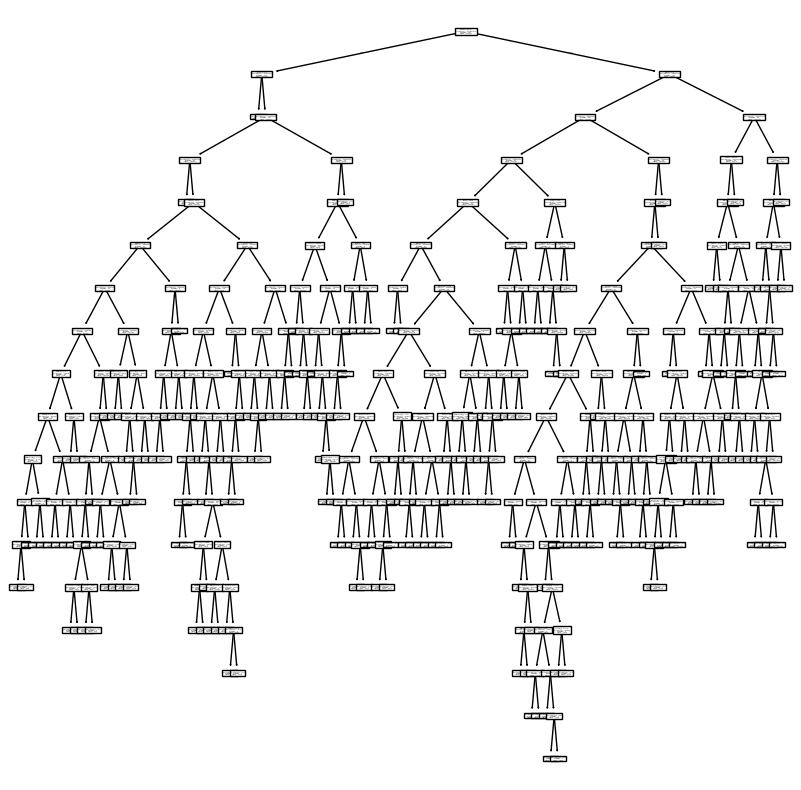

In [ ]:
#Revisión del Tree
plt.figure(figsize = (10, 10))
_ = plot_tree(tree_model, feature_names = feature_names)
#Resultado: No optimo

In [ ]:
#se realiza el Cross Validation
alphas = np.exp(np.linspace(-2, 10, 100))
folds = KFold(3, shuffle = True, random_state = 123)
rmses = np.zeros(alphas.shape)

for i, alpha in enumerate(alphas):
        tree = DecisionTreeRegressor(ccp_alpha = alpha, random_state = 123)
        results = cross_validate(tree, X_train, y_train, cv = folds, scoring = "neg_root_mean_squared_error")
        rmses[i] = (- results["test_score"]).mean()

In [ ]:
#Obtengo el alfa optimo para el DecisionTree
optimal_alpha = alphas[np.argmin(rmses)]
optimal_alpha

2485.3824203555578

In [ ]:
tree_model_prune = DecisionTreeRegressor(ccp_alpha = optimal_alpha, random_state = 123)
tree_model_prune.fit(X_train, y_train)
pruned_predictions = tree_model_prune.predict(X_test)
np.sqrt(((y_test - pruned_predictions) ** 2).mean())

540.4302005978491

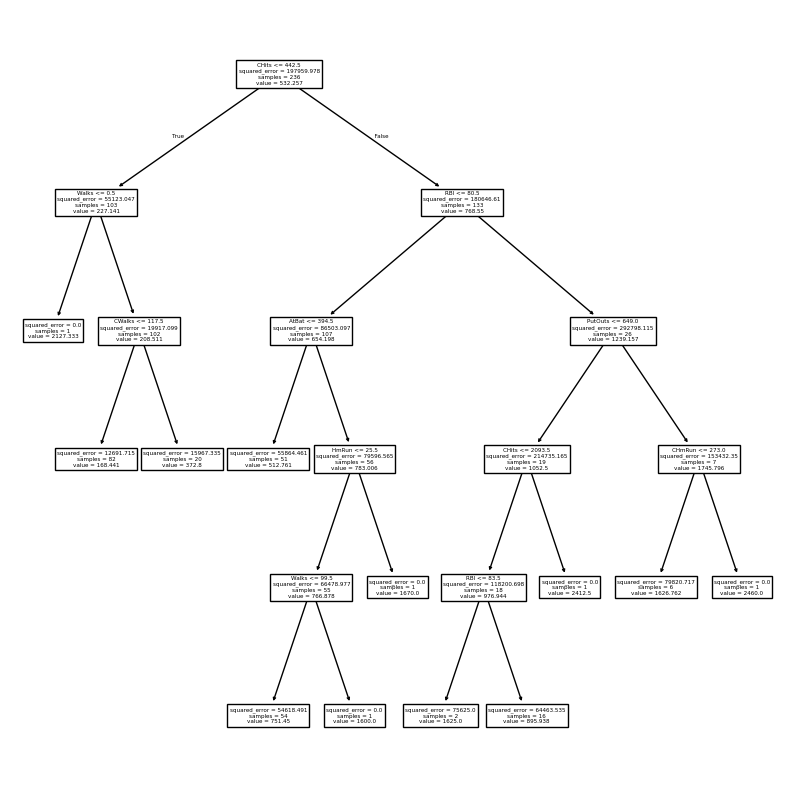

In [ ]:
plt.figure(figsize = (10, 10))
_ = plot_tree(tree_model_prune, feature_names = feature_names)

In [ ]:
# Realiza las predicciones sobre el conjunto de prueba
y_pred = tree_model.predict(X_test)
# Calcula el MSE 
oos_mse = mean_squared_error(y_test, y_pred)

# Imprime el resultado
print(f"Out of Sample Mean Squared Error: {oos_mse}")


Out of Sample Mean Squared Error: 373595.9007248889


3.5 Which model performs better in terms of predictive accuracy?

Al comparar el MSE de ambos modelos, el modelo de bootstrapping tiene un MSE de 208,822.04, mientras que el árbol de decisión tiene un MSE de 373,595.90. Dado que el MSE del modelo de bootstrapping es menor, este modelo presenta una mejor precisión predictiva según esta métrica.